# Questioning the Effect of Physiological Heartbeat Synchrony in Romantic Dyads. A Preregistered Deep Learning Analysis.

In [5]:
# For Google Colab / local machine
import tensorflow.keras
ver = tensorflow.version.VERSION

if float(ver[:3]) > 2.7:
  print("Latest TensorFlow version detected -> Prepare Google Colab usage\n")
  google_colab = 1
  from google.colab import drive
  drive.mount('/content/drive/')
  colab_path = "/content/drive/MyDrive/Masterarbeit/Code/two-hearts/"
  import sys
  sys.path.append(colab_path)
else:
  colab_path = ""

In [6]:
# Import libraries
import os
import datetime
import random
from random import randint
import pickle
import IPython
import IPython.display
import numpy as np
from numpy import array, hstack
import pandas as pd
import scipy.stats as st
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
# mpl.rcParams['font.family'] = 'Arial'
import seaborn as sns
from tensorflow.python.keras.saving import saving_utils
from tensorflow.keras.models import Sequential, Model, load_model
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

from lists import dyads, num_dyads, participants, num_participants

print("TensorFlow version:",tensorflow.version.VERSION)

TensorFlow version: 2.6.0


In [7]:
# Add headers for multiple subplots
# Based on https://stackoverflow.com/a/71887460
def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()
        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )
        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

## Deep Learning

In [8]:
# Load all results
with open('model/data_all.pickle', 'rb') as handle: # alternative: pd.read_pickle
    data_all = pickle.load(handle)

In [9]:
# Set sampling rate
sampling_rate = 50
print("Sampling rate:", sampling_rate)

# Set number of time steps
n_steps_in, n_steps_out = 5*sampling_rate, 2*sampling_rate
print("Time steps:", n_steps_in, n_steps_out)

# Set conditions
condition = ["sit","gaze","gaze_swap"]
print("Conditions:", condition)

# Show number of participants 
print("Participants:", num_participants)

# Show number of dyads
print("Dyads:", num_dyads)

# Show number of trials
trial = list(data_all.keys())
print("Number of training trials:",len(trial))

Sampling rate: 50
Time steps: 250 100
Conditions: ['sit', 'gaze', 'gaze_swap']
Participants: 8
Dyads: 4
Number of training trials: 3


### Summary

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 2)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 100), (None, 41200       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 100)          400         lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 100, 100)     0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

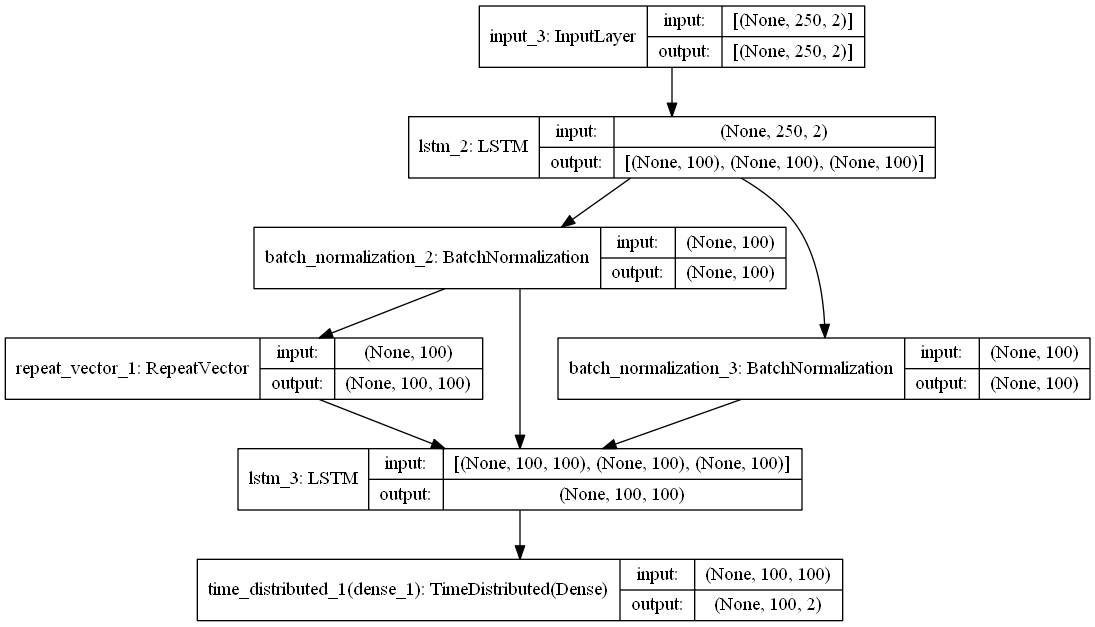

In [10]:
model = load_model(data_all["01"]["model_all"]["gaze"]) # install nomkl if kernel dies here because of kmp duplicate library
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='plots/keras_model_plot.png')

In [11]:
num_participants = len(participants)
num_dyads = len(dyads)

samples = data_all["01"]["samples_all"] # samples are the same for each trial
predictions = {}
for x in trial: 
    predictions[x] = (data_all[x]["predictions_all"])

len(samples["gaze"]["X_input_train"])
len(samples["gaze"]["y_output_train"])
len(samples["gaze"]["X_input_train"])

print("Number of participants:", 
      num_participants)
print("Number of dyads:", 
      num_dyads)
print("num_train_samples per dyad:", 
      len(samples["gaze"]["X_input_train"])//num_dyads)
print("num_vali_samples per dyad:", 
      len(samples["gaze"]["X_input_vali"])//num_dyads)
print("num_test_samples per dyad:", 
      len(samples["gaze"]["X_input_test"])//num_dyads)
print("Length of samples for each set:", 
      len(samples["gaze"]["X_input_train"]),
      len(samples["gaze"]["X_input_vali"]),
      len(samples["gaze"]["X_input_test"]))

Number of participants: 8
Number of dyads: 4
num_train_samples per dyad: 174
num_vali_samples per dyad: 58
num_test_samples per dyad: 58
Length of samples for each set: 696 232 232


### Evaluation

In [12]:
# Show saved evaluations
print("Metrics for all trials")

for x in trial: print(x, 
    data_all[x]["results_all"])

# Calculate means ans stds for both metrics
# MSE
mse_temp = []
mse_all = []
for i,x in enumerate(trial):
    for y in condition:
        mse_temp.append(data_all[x]["results_all"][y][0])
    mse_all.append(mse_temp)
    mse_temp = []

# MAE
mae_temp = []
mae_all = []
for i,x in enumerate(trial):
    for y in condition:
        mae_temp.append(data_all[x]["results_all"][y][1])
    mae_all.append(mae_temp)
    mae_temp = []

# Means
print("\nMeans")

losses_mean = pd.DataFrame(
    {"sit": [np.mean(np.array(mse_all)[:,0]),
             np.mean(np.array(mae_all)[:,0])],
     "gaze": [np.mean(np.array(mse_all)[:,1]), 
              np.mean(np.array(mae_all)[:,1])],
     "gaze_swap": [np.mean(np.array(mse_all)[:,2]), 
                   np.mean(np.array(mae_all)[:,2])]},
      index=(["MSE", "MAE"]))

print(losses_mean.T)

# STDs
print("\nSD")

losses_std = pd.DataFrame(
    {"sit": [np.std(np.array(mse_all)[:,0]), 
             np.std(np.array(mae_all)[:,0])],
     "gaze": [np.std(np.array(mse_all)[:,1]), 
              np.std(np.array(mae_all)[:,1])],
     "gaze_swap": [np.std(np.array(mse_all)[:,2]), 
                   np.std(np.array(mae_all)[:,2])]},
      index=(["MSE", "MAE"]))

print(losses_std.T)

# Get trial number of the highest performing model for each condition
best_trial = {}
for i in condition:
    best_trial[i] = trial[np.argmin([data_all[x]["results_all"][i][0] for x in trial])]

Metrics for all trials
01 {'sit': [0.03412344306707382, 0.1280253678560257], 'gaze': [0.032038114964962006, 0.12382735311985016], 'gaze_swap': [0.030033575370907784, 0.11803679168224335]}
02 {'sit': [0.030130933970212936, 0.11829802393913269], 'gaze': [0.029292883351445198, 0.1176370307803154], 'gaze_swap': [0.030807161703705788, 0.1181928887963295]}
03 {'sit': [0.028609776869416237, 0.11416899412870407], 'gaze': [0.029705995693802834, 0.1173463985323906], 'gaze_swap': [0.03177810087800026, 0.12182052433490753]}

Means
                MSE       MAE
sit        0.030955  0.120164
gaze       0.030346  0.119604
gaze_swap  0.030873  0.119350

SD
                MSE       MAE
sit        0.002325  0.005809
gaze       0.001209  0.002989
gaze_swap  0.000714  0.001748


In [13]:
# Sanity check
results_check = model.evaluate(
    samples["gaze"]["X_input_test"], 
    samples["gaze"]["y_output_test"], 
    batch_size=64, verbose=0)
print(results_check)
print(data_all["01"]["results_all"]["gaze"]) # compare with saved results from model notebook

[0.032038114964962006, 0.12382736802101135]
[0.032038114964962006, 0.12382735311985016]


### Training epochs

In [30]:
# Show training length in dataframe
 
# Prepare nested list
training_length_list = []
for i in trial: 
    temp = []
    for j in list(data_all["01"]["history_all"].keys()):
        temp.append(len(data_all[i]["history_all"][j]["loss"]))
    training_length_list.append(temp)
# Save nested list as dictionary
training_length_dict = {}
for i in range(len(training_length_list)):
    training_length_dict[f"Trial {i}"] = training_length_list[i]
# Transform dictionary into dataframe
training_length = pd.DataFrame.from_dict(
    training_length_dict, 
    orient='index', 
    columns=[list(data_all["01"]["history_all"].keys())])
training_length = training_length-50 # patience = 50

print("Training epochs:")
print(training_length)

training_length_info = pd.DataFrame(
    {"sit": [training_length.mean(axis=0)[0],
             training_length.std(axis=0)[0], 
             training_length.min(axis=0)[0], 
             training_length.max(axis=0)[0]],
     "gaze": [training_length.mean(axis=0)[1], 
              training_length.std(axis=0)[1], 
              training_length.min(axis=0)[1], 
              training_length.max(axis=0)[1]],
     "gaze_swap": [training_length.mean(axis=0)[2], 
                   training_length.std(axis=0)[2], 
                   training_length.min(axis=0)[2], 
                   training_length.max(axis=0)[2]]},
     index = (["Mean", "SD", "Min", "Max"]))

training_length_info = training_length_info.round(2)
print("\nTraining info:")
print(training_length_info)
print(f"\nMean training length: {training_length.mean().mean():.0f} epochs")


Training epochs:
         sit gaze gaze_swap
Trial 0  133  217       181
Trial 1  261  205       190
Trial 2  271  249       202

Training info:
         sit    gaze  gaze_swap
Mean  221.67  223.67     191.00
SD     76.95   22.74      10.54
Min   133.00  205.00     181.00
Max   271.00  249.00     202.00

Mean training length: 212 epochs


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


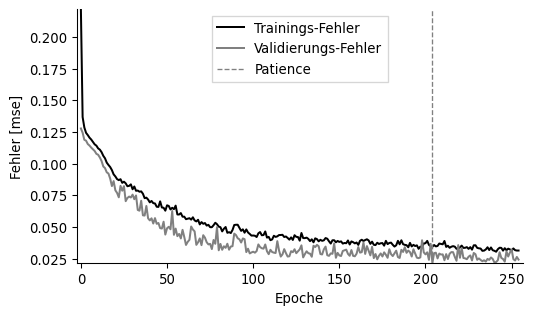

In [15]:
# Plot training loss for one neural net
history = data_all[best_trial["gaze"]]["history_all"]["gaze"]
print(history.keys())
train_loss = history['loss']
valid_loss = history['val_loss']

fig = plt.figure(figsize=(6,3.5), dpi=96)

# plt.title('Training- vs. Validation-Loss (mse)')
plt.ylabel('Fehler [mse]')
plt.xlabel('Epoche')
# plt.ylim(ymax = 0.2)
plt.margins(y=0,x=0.01)

plt.plot(train_loss, label='Trainings-Fehler', color="k"), 
plt.plot(valid_loss, label='Validierungs-Fehler', color="grey")

plt.vlines(
    x=(len(train_loss)-51),
    ymin=min(valid_loss), 
    ymax=max(train_loss), 
    colors='grey', 
    ls='--', lw=1, 
    label='Patience')
plt.legend(
    loc='upper center', 
    fancybox=False, 
    shadow=False, 
    ncol=1) #bbox_to_anchor=(0.5, -0.15)
sns.despine()

plt.savefig("plots/training_loss.png", dpi=512, bbox_inches='tight')

### Visualisation

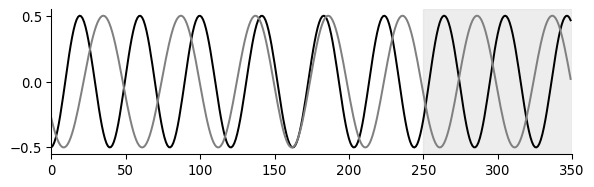

In [83]:
# Plot single sample
sample_no = 2

fig = plt.figure(figsize=(7,2), dpi=96)
sample_example = [
    np.append(
        samples["gaze"]["X_input_test"][sample_no,:,sex],
        samples["gaze"]["y_output_test"][sample_no,:,sex])
    for sex in [0,1]
    ]

plt.plot(sample_example[0], color="k", label = "Frau")
plt.plot(sample_example[1], color="grey", label = "Mann")
plt.margins(x=0)
plt.yticks([0.5,0,-0.5])
plt.axvspan(250,350, color='gainsboro', alpha=0.5)

sns.despine()

plt.savefig("plots/sample.png", dpi=512, bbox_inches='tight')

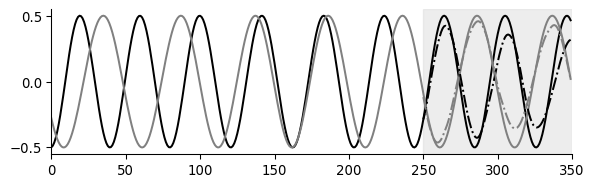

In [81]:
# Plot single sample with predictions
prediction_example = [
    np.append(
        np.full([len(samples["gaze"]["X_input_test"][sample_no,:,sex])], np.nan),  # add 250 nans at start
        predictions[best_trial["gaze"]]["gaze"][sample_no,:,sex])
    for sex in [0,1]
    ]

fig = plt.figure(figsize=(7,2), dpi=96)
plt.plot(sample_example[0], color="k", label = "Frau")
plt.plot(sample_example[1], color="grey", label = "Mann")
plt.plot(prediction_example[0], ls="-.", color="k", label = "Frau")
plt.plot(prediction_example[1], ls="-.", color="grey", label = "Mann")
plt.margins(x=0)
plt.yticks([0.5,0,-0.5])
plt.axvspan(250,350, color='gainsboro', alpha=0.5)

sns.despine()

plt.savefig("plots/sample2.png", dpi=512, bbox_inches='tight')

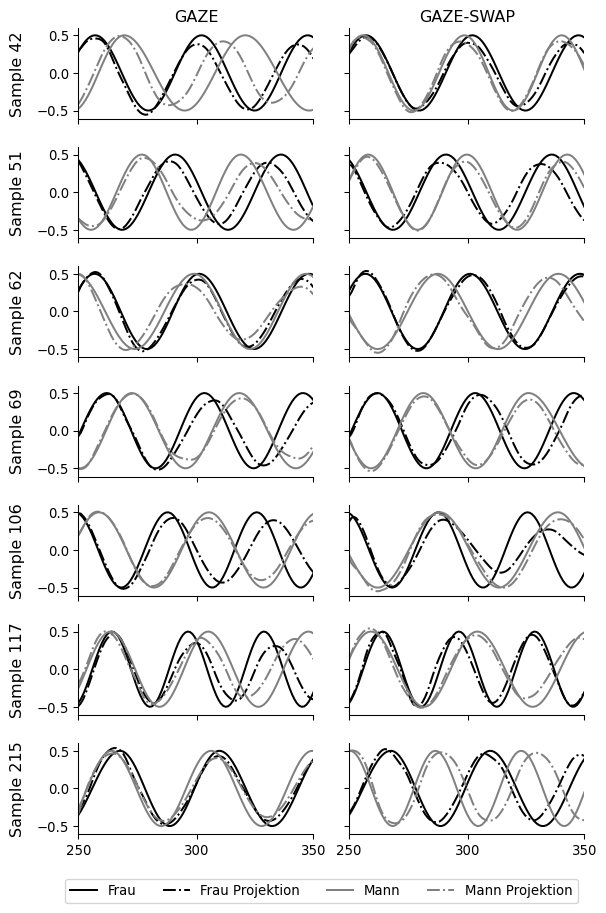

In [31]:
# Get random sample indices
sample_no = np.sort([randint(0, len(samples["gaze"]["y_output_test"])) for p in range(0, 7)])

n_rows = len(sample_no)
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols,figsize=(6,9), dpi=96, sharey=True, sharex=True)
# fig.suptitle('Main title')
fig.tight_layout()

for row_num in range(n_rows):
    for col_num in range(n_cols):
        if col_num == 0:
            ax = axes[row_num][col_num]
            ax.plot(samples["gaze"]["y_output_test"][sample_no[row_num],:,0],
                    color="black", label="Frau")
            ax.plot(predictions[best_trial["gaze"]]["gaze"][sample_no[row_num],:,0], 
                    color="black", ls="-.", label="Frau Projektion")
            ax.plot(samples["gaze"]["y_output_test"][sample_no[row_num],:,1], 
                    color="grey", label="Mann")
            ax.plot(predictions[best_trial["gaze"]]["gaze"][sample_no[row_num],:,1],
                    color="grey", ls="-.", label="Mann Projektion")
            # ax.set_title(f'Plot ({row_num+1}, {col_num+1})')
            ax.set_xticks([0,50,99])
            ax.set_xticklabels([250,300,350])
            ax.set_yticks([-0.5,0,0.5])
            ax.margins(x=0)
        elif col_num == 1:
            ax = axes[row_num][col_num]
            ax.plot(samples["gaze_swap"]["y_output_test"][sample_no[row_num],:,0], 
                    color="black")
            ax.plot(predictions[best_trial["gaze_swap"]]["gaze_swap"][sample_no[row_num],:,0], 
                    color="black", ls="-.")
            ax.plot(samples["gaze_swap"]["y_output_test"][sample_no[row_num],:,1], 
                    color="grey")
            ax.plot(predictions[best_trial["gaze_swap"]]["gaze_swap"][sample_no[row_num],:,1], 
                    color="grey", ls="-.")
            ax.set_xticks([0,50,99])
            ax.set_xticklabels([250,300,350])
            ax.set_yticks([-0.5,0,0.5])
            ax.margins(x=0)
sns.despine()

row_headers = [f"Sample {str(x)}" for x in sample_no]
col_headers = ["GAZE", "GAZE-SWAP"]
font_kwargs = dict(fontsize="large")#fontweight="bold")#, )#, fontfamily="monospace")
add_headers(fig, col_headers=col_headers, row_headers=row_headers, **font_kwargs)

# Code for legend based on https://stackoverflow.com/a/59393045
labels_handles = {
  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}

fig.legend(
  labels_handles.values(),
  labels_handles.keys(),
  loc="upper center",
  bbox_to_anchor=(0.5, 0),
  bbox_transform=plt.gcf().transFigure,
  ncol=4
)
plt.savefig("plots/samples_pred.png", dpi=512, bbox_inches='tight')

plt.show()

In [86]:
# Correlation between ground truth and projections for each gender
correlation_dict = {}
for x in condition: 
    correlation_dict[x] = {}  # prepare nested dictionary

for j in condition:
    for k, sex in enumerate(["f","m"]):
        correlation_dict[j][sex] = [
            np.corrcoef(
                predictions[best_trial[j]][j][:,:,k][i],
                samples[j]["y_output_test"][:,:,k][i])[0,1]
            for i in range(len(predictions[best_trial[j]][j]))
            ]

correlation_mean = pd.DataFrame(
    {"Female": [np.mean(correlation_dict["sit"]["f"]),
                np.mean(correlation_dict["gaze"]["f"]),
                np.mean(correlation_dict["gaze_swap"]["f"]),
                np.mean(
                    [*correlation_dict["sit"]["f"],
                    *correlation_dict["gaze"]["f"],
                    *correlation_dict["gaze_swap"]["f"]])],
     "Male": [np.mean(correlation_dict["sit"]["m"]),
              np.mean(correlation_dict["gaze"]["m"]),
              np.mean(correlation_dict["gaze_swap"]["m"]),
              np.mean(
                  [*correlation_dict["sit"]["m"],
                   *correlation_dict["gaze"]["m"],
                   *correlation_dict["gaze_swap"]["m"]])]},
    index=["SIT", "GAZE", "GAZE-SWAP", "ALL"])
print(correlation_mean)

correlation_std = pd.DataFrame(
    {"Female": [np.std(correlation_dict["sit"]["f"]),
                np.std(correlation_dict["gaze"]["f"]),
                np.std(correlation_dict["gaze_swap"]["f"]),
                np.std(
                    [*correlation_dict["sit"]["f"],
                    *correlation_dict["gaze"]["f"],
                    *correlation_dict["gaze_swap"]["f"]])],
     "Male": [np.std(correlation_dict["sit"]["m"]),
              np.std(correlation_dict["gaze"]["m"]),
              np.std(correlation_dict["gaze_swap"]["m"]),
              np.std(
                  [*correlation_dict["sit"]["m"],
                   *correlation_dict["gaze"]["m"],
                   *correlation_dict["gaze_swap"]["m"]])]},
    index=["SIT", "GAZE", "GAZE-SWAP", "ALL"])
print(correlation_std)


             Female      Male
SIT        0.873388  0.886897
GAZE       0.854070  0.899691
GAZE-SWAP  0.856628  0.894597
ALL        0.861362  0.893728
             Female      Male
SIT        0.162797  0.160636
GAZE       0.227778  0.126972
GAZE-SWAP  0.212553  0.134653
ALL        0.203129  0.141586


### Data Distribution

In [20]:
data_final = {
  "test_pred": predictions[best_trial["gaze_swap"]]["gaze_swap"],
  "test_true": samples["gaze_swap"]["y_output_test"]
}

data_final_keys = list(data_final.keys())
data_final_keys

['test_pred', 'test_true']

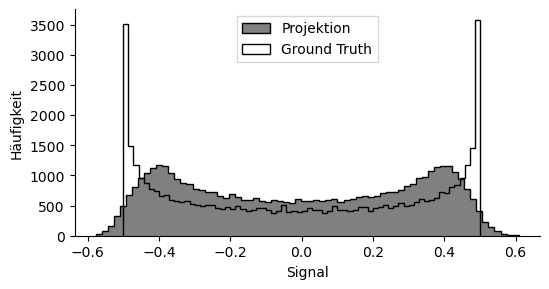

In [21]:
# Plot value distribution
# test data
plt.figure(figsize=(6, 3), dpi=100)

# plt.title('value distribution: '+lb)
plt.xlabel('Signal')
plt.ylabel('Häufigkeit')

plt.hist(data_final['test_pred'].flatten(), bins=70, histtype='step', edgecolor='black', fill=True, color='grey', label='Projektion')
plt.hist(data_final['test_true'].flatten(), bins=70, histtype='step', edgecolor='black', fill=False, label='Ground Truth')
plt.legend(loc='upper center', fancybox=False, shadow=False, ncol=1) #bbox_to_anchor=(0.5, -0.15)

sns.despine()
plt.savefig("plots/data_distribution.png", dpi=512, bbox_inches='tight')

plt.show()

### Miscellaneous
Code from:
https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [22]:
# plot MAE of all samples in time order, to see if there is clear pattern (which means more training is needed)
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

KeyError: 'train_pred'

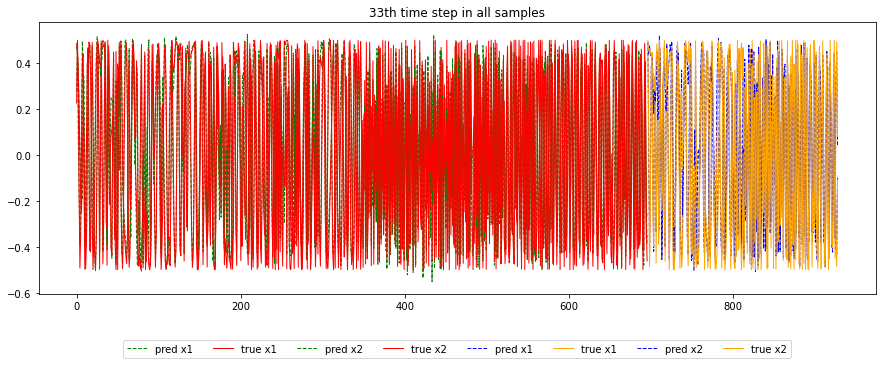

In [ ]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

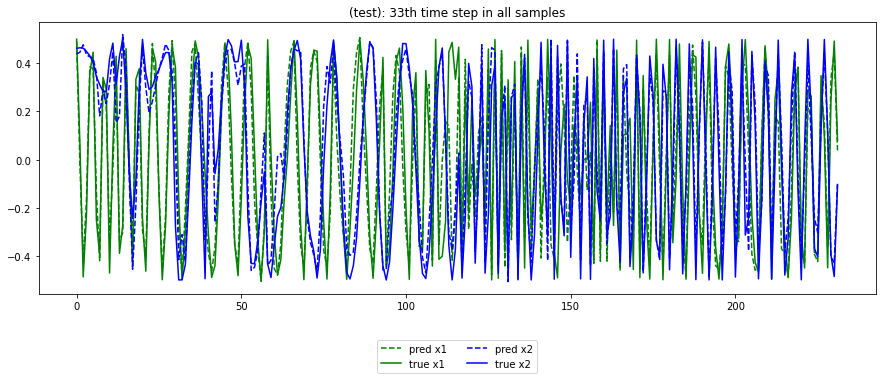

In [ ]:
# Check the nth prediction of each time step
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()